In [4]:
!rm -rf /content/drive

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
import os, json, random
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding,
                          set_seed)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
else:
    raise SystemError("No GPU detected. Switch Runtime to GPU.")
set_seed(42)

Torch: 2.8.0+cu126
CUDA available: True
Device name: Tesla T4


In [7]:
# Paths
BASE = "/content/drive/MyDrive/GenAI"
GPT2_DIR = f"{BASE}/GPT2-data"            # jsonl: xl-1542M.*.jsonl  (AI)
WEBTEXT_TRAIN = f"{GPT2_DIR}/webtext.train.jsonl"  # human
WEBTEXT_VALID = f"{GPT2_DIR}/webtext.valid.jsonl"
WEBTEXT_TEST  = f"{GPT2_DIR}/webtext.test.jsonl"

GPT35_CSV = f"{BASE}/GPT35-data/gpt35_outputs.csv"
GPT4_CSV  = f"{BASE}/GPT4-data/gpt4_outputs.csv"
OUT_DIR   = f"{BASE}/models/roberta-detector"

os.makedirs(OUT_DIR, exist_ok=True)

# Target sizes (feel free to adjust)
N_GPT2_TRAIN   = 5000   # AI for training
N_HUMAN_TRAIN  = 5000   # Human for training
N_GPT35_TEST   = 2000
N_GPT4_TEST    = 2000
N_HUMAN_TEST   = 2000

MIN_WORDS = 50
MAX_WORDS = 400
MAX_LENGTH_TOKENS = 256  # tokenizer max_length

In [8]:
def stream_jsonl_texts(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                txt = (obj.get("text") or "").strip()
                if txt:
                    yield txt
            except json.JSONDecodeError:
                continue

def filter_by_word_count(texts, lo=MIN_WORDS, hi=MAX_WORDS):
    out = []
    for t in texts:
        wc = len(t.split())
        if lo <= wc <= hi:
            out.append(t)
    return out

def sample_list(lst, n, seed=42):
    random.seed(seed)
    if len(lst) <= n:
        return lst
    return random.sample(lst, n)

# Load GPT-2 AI (xl-1542M*.jsonl) as one big generator
def load_gpt2_ai_texts(gpt2_dir, cap=None):
    import glob
    texts = []
    for fp in glob.glob(os.path.join(gpt2_dir, "xl-1542M*.jsonl")):
        for t in stream_jsonl_texts(fp):
            texts.append(t)
            if cap and len(texts) >= cap*3:  # read a bit more before filter
                break
        if cap and len(texts) >= cap*3:
            break
    return texts

# Load Human from webtext.*.jsonl
def load_human_texts():
    texts = []
    for p in [WEBTEXT_TRAIN, WEBTEXT_VALID, WEBTEXT_TEST]:
        if os.path.exists(p):
            texts.extend(list(stream_jsonl_texts(p)))
    return texts

# Load GPT-3.5 / GPT-4 CSV
def load_csv_texts(path):
    df = pd.read_csv(path)
    assert "text" in df.columns, "CSV must contain 'text' column."
    return df["text"].dropna().astype(str).tolist()

# Read
gpt2_ai_raw   = load_gpt2_ai_texts(GPT2_DIR, cap=N_GPT2_TRAIN)
human_raw     = load_human_texts()
gpt35_raw     = load_csv_texts(GPT35_CSV)
gpt4_raw      = load_csv_texts(GPT4_CSV)

# Filter by length
gpt2_ai = filter_by_word_count(gpt2_ai_raw)
human   = filter_by_word_count(human_raw)
gpt35   = filter_by_word_count(gpt35_raw)
gpt4    = filter_by_word_count(gpt4_raw)

print({ "gpt2_ai": len(gpt2_ai),
        "human": len(human),
        "gpt35": len(gpt35),
        "gpt4": len(gpt4) })


{'gpt2_ai': 5959, 'human': 117831, 'gpt35': 1834, 'gpt4': 1747}


In [9]:
# Sample to targets (will auto cap if not enough)
gpt2_train = sample_list(gpt2_ai,  N_GPT2_TRAIN)
human_train_full = sample_list(human, N_HUMAN_TRAIN + N_HUMAN_TEST)  # reserve human holdout for test
human_train = human_train_full[:N_HUMAN_TRAIN]
human_test  = human_train_full[N_HUMAN_TRAIN:N_HUMAN_TRAIN + N_HUMAN_TEST]

gpt35_test = sample_list(gpt35, N_GPT35_TEST)
gpt4_test  = sample_list(gpt4,  N_GPT4_TEST)

# Build DataFrames
train_df = pd.DataFrame({
    "text": gpt2_train + human_train,
    "label": [1]*len(gpt2_train) + [0]*len(human_train),
    "source_model": ["GPT-2"]*len(gpt2_train) + ["human"]*len(human_train)
})

# 20% validation from the training sources (stratified)
from sklearn.model_selection import train_test_split
train_df, val_df = train_df.reset_index(drop=True), None
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["label"], random_state=42
)

test_df = pd.DataFrame({
    "text": gpt35_test + gpt4_test + human_test,
    "label": [1]*len(gpt35_test) + [1]*len(gpt4_test) + [0]*len(human_test),
    "source_model": (["GPT-3.5"]*len(gpt35_test)) + (["GPT-4"]*len(gpt4_test)) + (["human"]*len(human_test))
})

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))
train_df.head()


Train/Val/Test sizes: 8000 2000 5581


,text,label,source_model
7858,"""This is going to happen again and again until...",0,human
1842,FORT LAUDERDALE – One of four men accused of r...,1,GPT-2
8905,"""Our job at the Department of Defense, as you ...",0,human
2684,Fancy a round of golf on the links? You betcha...,1,GPT-2
6564,Brussels suicide bombers Khalid and Ibrahim El...,0,human


In [10]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH_TOKENS,
        padding=False
    )

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})
ds_tokenized = ds.map(tokenize_fn, batched=True, remove_columns=["text","source_model"])
collator = DataCollatorWithPadding(tokenizer=tokenizer)
num_labels = 2

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5581 [00:00<?, ? examples/s]

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

bsz = 16                 # if OOM on T4, reduce to 8
grad_accum = 2           # effective batch size = bsz * grad_accum
lr = 2e-5
epochs = 3               # extend to 4–5 if loss still going down

args = TrainingArguments(
    output_dir=OUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=lr,
    per_device_train_batch_size=bsz,
    per_device_eval_batch_size=bsz,
    gradient_accumulation_steps=grad_accum,
    num_train_epochs=epochs,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    report_to="none"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    try:
        # Need probabilities for positive class
        probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()[:,1]
        auc = roc_auc_score(labels, probs)
    except Exception:
        auc = float("nan")
    return {"accuracy": acc, "f1": f1, "auc": auc}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,0.246000,0.778024,0.760500,0.805047,0.970906
2,0.115400,0.516912,0.871500,0.885523,0.988465
3,0.050600,0.471115,0.910500,0.917168,0.988972


Could not locate the best model at /content/drive/MyDrive/GenAI/models/roberta-detector/checkpoint-750/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=750, training_loss=0.19019351800282797, metrics={'train_runtime': 431.8116, 'train_samples_per_second': 55.58, 'train_steps_per_second': 1.737, 'total_flos': 3157332664320000.0, 'train_loss': 0.19019351800282797, 'epoch': 3.0})

In [15]:
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)
print("Model saved to:", OUT_DIR)

Model saved to: /content/drive/MyDrive/GenAI/models/roberta-detector


In [16]:
# Overall test set
test_metrics = trainer.evaluate(ds_tokenized["test"])
print("Test overall:", test_metrics)

# By source_model
def eval_subset(df, name):
    sub = Dataset.from_pandas(df, preserve_index=False)
    sub_tok = sub.map(tokenize_fn, batched=True, remove_columns=["text","source_model"])
    m = trainer.evaluate(sub_tok)
    print(f"{name}:", m)

eval_subset(test_df[test_df["source_model"]=="GPT-3.5"], "Test GPT-3.5")
eval_subset(test_df[test_df["source_model"]=="GPT-4"],   "Test GPT-4")
eval_subset(test_df[test_df["source_model"]=="human"],   "Test human holdout")


Test overall: {'eval_loss': 1.8922429084777832, 'eval_accuracy': 0.6319655975631607, 'eval_f1': 0.6464716006884682, 'eval_auc': 0.7754196453504607, 'eval_runtime': 28.3511, 'eval_samples_per_second': 196.853, 'eval_steps_per_second': 12.31, 'epoch': 3.0}


Map:   0%|          | 0/1834 [00:00<?, ? examples/s]

Test GPT-3.5: {'eval_loss': 2.148019790649414, 'eval_accuracy': 0.5517993456924755, 'eval_f1': 0.7111735769501054, 'eval_auc': nan, 'eval_runtime': 7.74, 'eval_samples_per_second': 236.952, 'eval_steps_per_second': 14.858, 'epoch': 3.0}


Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Test GPT-4: {'eval_loss': 2.7836227416992188, 'eval_accuracy': 0.4957069261591299, 'eval_f1': 0.6628396479142747, 'eval_auc': nan, 'eval_runtime': 4.0674, 'eval_samples_per_second': 429.516, 'eval_steps_per_second': 27.044, 'epoch': 3.0}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Test human holdout: {'eval_loss': 0.879226565361023, 'eval_accuracy': 0.8245, 'eval_f1': 0.0, 'eval_auc': nan, 'eval_runtime': 9.3418, 'eval_samples_per_second': 214.092, 'eval_steps_per_second': 13.381, 'epoch': 3.0}


In [17]:
def predict_texts(texts):
    enc = tokenizer(texts, truncation=True, max_length=MAX_LENGTH_TOKENS, return_tensors="pt", padding=True)
    enc = {k: v.to(trainer.model.device) for k, v in enc.items()}
    with torch.no_grad():
        logits = trainer.model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = probs.argmax(1)
    return preds, probs[:,1]

preds, probs = predict_texts([
    "This paragraph discusses how transformers work in natural language processing...",
    "In the grand tapestry of existence, one often wonders about the ineffable essence..."
])
list(zip(preds, probs))

[(0, 0.0015188509), (0, 0.08694165)]

In [18]:
## visual
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [19]:
results = {
    "GPT-2 (validation)": {"Accuracy": 0.90, "F1": 0.90},
    "GPT-3.5": {"Accuracy": 0.55, "F1": 0.71},
    "GPT-4": {"Accuracy": 0.50, "F1": 0.66},
    "Human holdout": {"Accuracy": 0.82, "F1": 0.00}
}

df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
df

,Model,Accuracy,F1
0,GPT-2 (validation),0.90,0.90
1,GPT-3.5,0.55,0.71
2,GPT-4,0.50,0.66
3,Human holdout,0.82,0.00


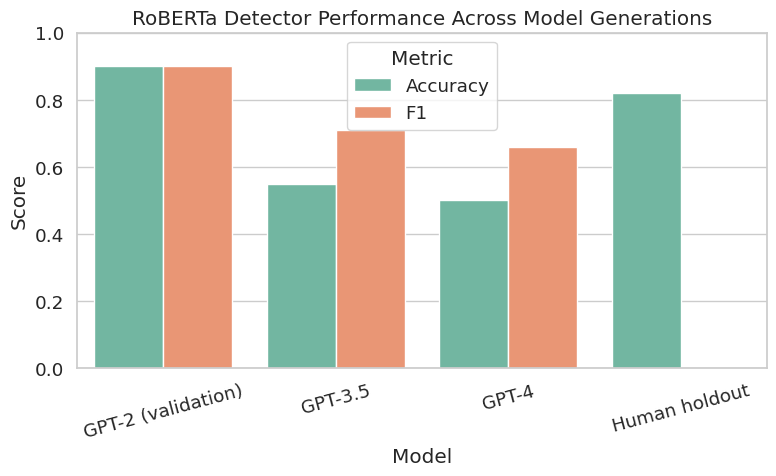

In [20]:
sns.set(style="whitegrid", font_scale=1.2)

df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
df_melt = df.melt(id_vars="Model", value_vars=["Accuracy", "F1"], var_name="Metric", value_name="Score")

plt.figure(figsize=(8,5))
sns.barplot(data=df_melt, x="Model", y="Score", hue="Metric", palette="Set2")
plt.title("RoBERTa Detector Performance Across Model Generations")
plt.ylabel("Score")
plt.ylim(0,1.0)
plt.legend(title="Metric")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


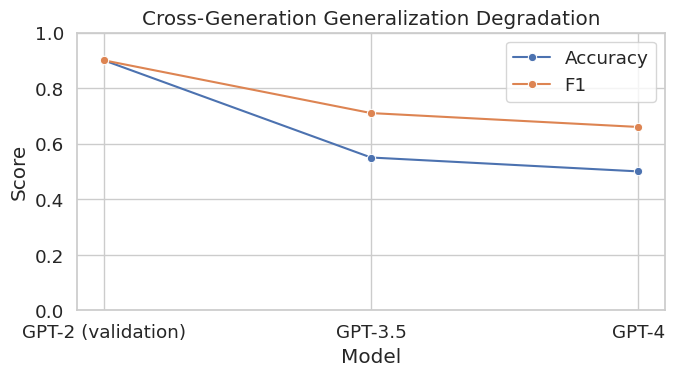

In [21]:
plt.figure(figsize=(7,4))
order = ["GPT-2 (validation)", "GPT-3.5", "GPT-4"]
sns.lineplot(data=df[df["Model"].isin(order)], x="Model", y="Accuracy", marker="o", label="Accuracy")
sns.lineplot(data=df[df["Model"].isin(order)], x="Model", y="F1", marker="o", label="F1")
plt.title("Cross-Generation Generalization Degradation")
plt.ylabel("Score")
plt.ylim(0,1.0)
plt.legend()
plt.tight_layout()
plt.show()